# Omdena Nytrolytics AI Challenge

Determining the Water Retention Capacity of Naturally Fertilized Soil Through Machine Learning
https://omdena.com/projects/determining-the-water-retention-capacity-of-naturally-fertilized-soil/


#### XGBoost Regression + Hyperparameter Tuning with Optuna

Wallace G. Ferreira

# Imports

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, max_error, r2_score, mean_squared_error

from sklearn.model_selection import cross_val_score

In [4]:
import xgboost as xgb

In [5]:
import optuna

# Load Database

In [6]:
df = pd.read_csv('WRC_dataset_carbon_selected_dropna_no-outliers.csv',low_memory=False)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28141 entries, 0 to 28140
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   db_od         28141 non-null  float64
 1   oc            28141 non-null  float64
 2   sand_tot_psa  28141 non-null  float64
 3   silt_tot_psa  28141 non-null  float64
 4   clay_tot_psa  28141 non-null  float64
 5   lab_head_m    28141 non-null  float64
 6   lab_wrc       28141 non-null  float64
 7   thetar        28141 non-null  float64
 8   thetas        28141 non-null  float64
dtypes: float64(9)
memory usage: 1.9 MB


# Correlation Matrix

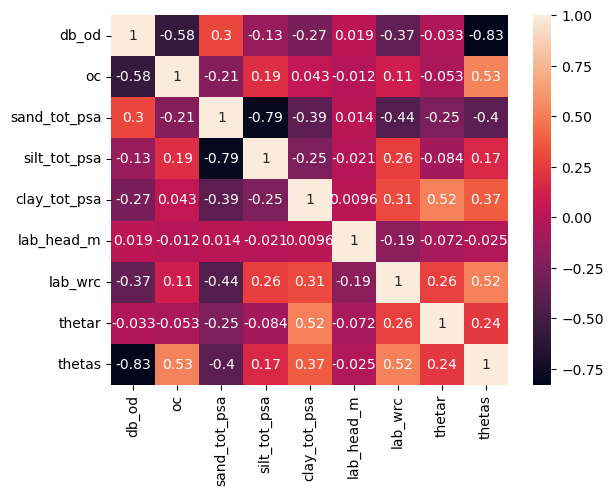

In [8]:
corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True)
plt.show()

# Create X and y Data to Feed ML Models

In [9]:
df.shape

(28141, 9)

In [10]:
df.columns

Index(['db_od', 'oc', 'sand_tot_psa', 'silt_tot_psa', 'clay_tot_psa',
       'lab_head_m', 'lab_wrc', 'thetar', 'thetas'],
      dtype='object')

In [11]:
X = np.array(df[['db_od', 'oc', 'sand_tot_psa', 'silt_tot_psa', 'clay_tot_psa','lab_head_m', 'thetar', 'thetas']].copy())
y = np.array(df['lab_wrc'].copy())

In [12]:
(X.shape,y.shape)

((28141, 8), (28141,))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2023)

In [14]:
(X_train.shape,y_train.shape)

((21105, 8), (21105,))

In [15]:
(X_test.shape,y_test.shape)

((7036, 8), (7036,))

In [16]:
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Auxiliary Functions for Model Metrics

In [17]:
def model_error_metrics(y_test,y_pred):
    R2 = r2_score(y_test, y_pred)
    ME = max_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)    
    return R2, ME, MAE, MAPE


def print_model_results(model_name,y_test,y_pred):
    R2, ME, MAE, MAPE = model_error_metrics(y_test,y_pred)
    print(f'{model_name}:  R^2= {R2:.4f},  ME = {ME:.4f},  MAE = {MAE:.4f},  MAPE = {MAPE:.4f}') 
    return None

# XGBoost

In [18]:
xgb_reg = xgb.XGBRegressor().fit(X_train_s, y_train)

In [19]:
importance = xgb_reg.feature_importances_

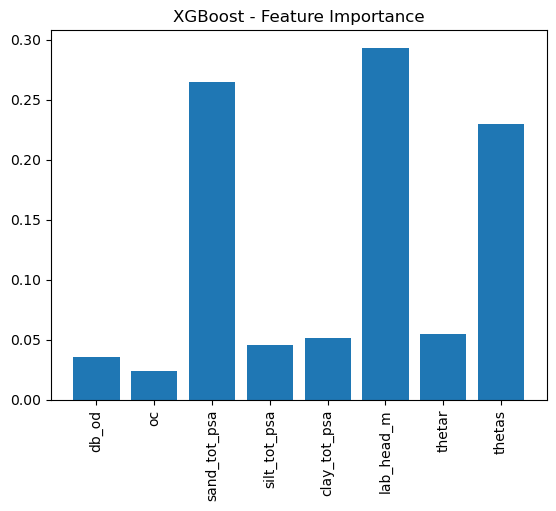

In [20]:
labels = ['db_od', 'oc', 'sand_tot_psa', 'silt_tot_psa', 'clay_tot_psa','lab_head_m', 'thetar', 'thetas']
plt.bar(labels, importance)
plt.xticks(rotation = 90)
plt.title('XGBoost - Feature Importance')
plt.show()

In [21]:
y_pred = xgb_reg.predict(X_test_s)

print_model_results('XGBoost Rregression', y_test,y_pred)

XGBoost Rregression:  R^2= 0.9692,  ME = 0.2203,  MAE = 0.0155,  MAPE = 0.0693


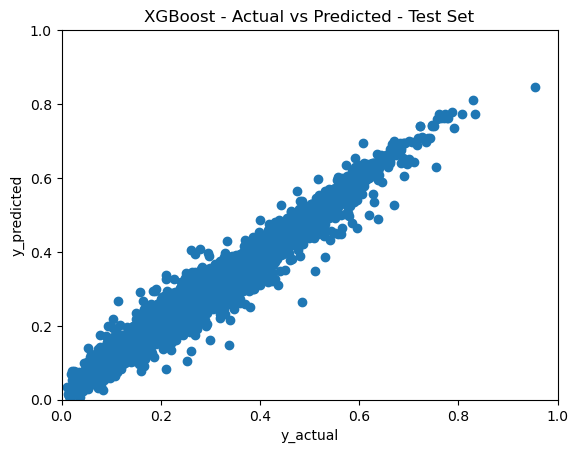

In [22]:
y_actual = y_test
plt.scatter(y_actual, y_pred)
plt.ylabel('y_predicted')
plt.xlabel('y_actual')
plt.title('XGBoost - Actual vs Predicted - Test Set')
plt.xlim((0,1))
plt.ylim((0,1))
plt.show()

# XGBoost - Hyperparameter Tuning - Optuna

In [23]:
def objective(trial):
   
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=100),
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear']),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42
    }
    
    # Train and evaluate XGBoost model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)
    return mse

In [24]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-06-02 11:17:20,567] A new study created in memory with name: no-name-249a3b9b-dff8-4840-b131-afad0de24e65


[11:17:20] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-02 11:17:24,081] Trial 0 finished with value: 0.0008756558659463943 and parameters: {'n_estimators': 1300, 'booster': 'gbtree', 'learning_rate': 0.0787727661741414, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 8, 'subsample': 0.7243923897904883, 'colsample_bytree': 0.6500516168274298, 'lambda': 0.49841989935076053, 'alpha': 0.951587899021842, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0008756558659463943.


[11:17:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-02 11:17:32,238] Trial 1 finished with value: 0.0003757996757725444 and parameters: {'n_estimators': 800, 'booster': 'gbtree', 'learning_rate': 0.020479367485342587, 'max_depth': 13, 'min_samples_split': 13, 'min_samples_leaf': 18, 'subsample': 0.753813538759122, 'colsample_bytree': 0.5201446607360741, 'lambda': 0.5044526431695672, 'alpha': 0.08033226729799846, 'max_features': 'log2'}. Best is trial 1 with value: 0.0003757996757725444.


[11:17:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "max_features", "min_samples_leaf", "min_samples_split", "subsample" } are not used.



[I 2023-06-02 11:17:34,694] Trial 2 finished with value: 0.014300043914804378 and parameters: {'n_estimators': 1900, 'booster': 'gblinear', 'learning_rate': 0.07811225607026254, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 12, 'subsample': 0.5133170676574623, 'colsample_bytree': 0.9358442917051721, 'lambda': 0.8275628426715851, 'alpha': 0.6077163294134839, 'max_features': 'log2'}. Best is trial 1 with value: 0.0003757996757725444.


[11:17:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-02 11:17:36,875] Trial 3 finished with value: 0.00045468546591463004 and parameters: {'n_estimators': 300, 'booster': 'gbtree', 'learning_rate': 0.027017016722418935, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.9867136549509536, 'colsample_bytree': 0.6880829139414768, 'lambda': 0.04526855699273738, 'alpha': 0.020557856289663928, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.0003757996757725444.


[11:17:36] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-02 11:17:45,581] Trial 4 finished with value: 0.00033330788553696507 and parameters: {'n_estimators': 800, 'booster': 'gbtree', 'learning_rate': 0.07089361264761998, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.660375761029556, 'colsample_bytree': 0.7252740542987133, 'lambda': 0.40708525449606037, 'alpha': 0.09893146339664641, 'max_features': 'log2'}. Best is trial 4 with value: 0.00033330788553696507.


[11:17:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "max_features", "min_samples_leaf", "min_samples_split", "subsample" } are not used.



[I 2023-06-02 11:17:46,138] Trial 5 finished with value: 0.013279739494870442 and parameters: {'n_estimators': 1000, 'booster': 'gblinear', 'learning_rate': 0.03218893527524401, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 16, 'subsample': 0.766766772574982, 'colsample_bytree': 0.9659863686502834, 'lambda': 0.955684364866847, 'alpha': 0.05544924482845431, 'max_features': 'log2'}. Best is trial 4 with value: 0.00033330788553696507.


[11:17:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "max_features", "min_samples_leaf", "min_samples_split", "subsample" } are not used.



[I 2023-06-02 11:17:48,753] Trial 6 finished with value: 0.014125354178910091 and parameters: {'n_estimators': 1800, 'booster': 'gblinear', 'learning_rate': 0.05914113977028165, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 17, 'subsample': 0.9433780458809866, 'colsample_bytree': 0.6607939028547007, 'lambda': 0.9098386907324726, 'alpha': 0.5066003703523795, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.00033330788553696507.
[I 2023-06-02 11:17:48,930] Trial 7 finished with value: 0.014030544210811503 and parameters: {'n_estimators': 300, 'booster': 'gblinear', 'learning_rate': 0.017845243210041162, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 19, 'subsample': 0.6260150917902891, 'colsample_bytree': 0.7657283115303912, 'lambda': 0.9251684207221136, 'alpha': 0.758086960473652, 'max_features': 'log2'}. Best is trial 4 with value: 0.00033330788553696507.


[11:17:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "max_features", "min_samples_leaf", "min_samples_split", "subsample" } are not used.

[11:17:48] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-02 11:18:02,436] Trial 8 finished with value: 0.00036781569247887645 and parameters: {'n_estimators': 1900, 'booster': 'gbtree', 'learning_rate': 0.023569133611445095, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.6942116675993608, 'colsample_bytree': 0.6936497831144647, 'lambda': 0.9800987602608566, 'alpha': 0.31483367771247645, 'max_features': 'log2'}. Best is trial 4 with value: 0.00033330788553696507.


[11:18:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth", "max_features", "min_samples_leaf", "min_samples_split", "subsample" } are not used.



[I 2023-06-02 11:18:03,618] Trial 9 finished with value: 0.013270339925057434 and parameters: {'n_estimators': 900, 'booster': 'gblinear', 'learning_rate': 0.09440222779057138, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 16, 'subsample': 0.7064881842831207, 'colsample_bytree': 0.8003448051858874, 'lambda': 0.5955978177357004, 'alpha': 0.045675873352920726, 'max_features': 'log2'}. Best is trial 4 with value: 0.00033330788553696507.


[11:18:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-02 11:18:19,790] Trial 10 finished with value: 0.0011928980013299515 and parameters: {'n_estimators': 1300, 'booster': 'gbtree', 'learning_rate': 0.002125542151467423, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 11, 'subsample': 0.8610103187590087, 'colsample_bytree': 0.8570286835177523, 'lambda': 0.2303091486199489, 'alpha': 0.2616866164489525, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.00033330788553696507.


[11:18:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-02 11:18:34,587] Trial 11 finished with value: 0.00033858918479410675 and parameters: {'n_estimators': 1500, 'booster': 'gbtree', 'learning_rate': 0.04813546961835431, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 1, 'subsample': 0.6283829421501748, 'colsample_bytree': 0.7210124538358414, 'lambda': 0.6979240345587542, 'alpha': 0.25626458644312733, 'max_features': 'log2'}. Best is trial 4 with value: 0.00033330788553696507.


[11:18:34] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-02 11:18:50,585] Trial 12 finished with value: 0.0003264727097547319 and parameters: {'n_estimators': 1500, 'booster': 'gbtree', 'learning_rate': 0.05154716269317161, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 1, 'subsample': 0.6021332270673967, 'colsample_bytree': 0.816783172528617, 'lambda': 0.6866900330980934, 'alpha': 0.2578975788293447, 'max_features': 'log2'}. Best is trial 12 with value: 0.0003264727097547319.


[11:18:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-02 11:18:57,380] Trial 13 finished with value: 0.0003727547436084151 and parameters: {'n_estimators': 600, 'booster': 'gbtree', 'learning_rate': 0.05796215356007011, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 1, 'subsample': 0.5328858675548387, 'colsample_bytree': 0.8450892152284561, 'lambda': 0.3329540618503416, 'alpha': 0.33342332148225545, 'max_features': 'log2'}. Best is trial 12 with value: 0.0003264727097547319.


[11:18:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[W 2023-06-02 11:19:11,254] Trial 14 failed with parameters: {'n_estimators': 1400, 'booster': 'gbtree', 'learning_rate': 0.04526569814417858, 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 8, 'subsample': 0.5960091402492852, 'colsample_bytree': 0.8895143043439548, 'lambda': 0.7243795204812563, 'alpha': 0.1725980185979965, 'max_features': 'log2'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\walla\anaconda3\envs\omdena_nitrolytics\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\walla\AppData\Local\Temp\ipykernel_131756\3739398164.py", line 22, in objective
    model.fit(X_train, y_train)
  File "c:\Users\walla\anaconda3\envs\omdena_nitrolytics\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\walla\anaconda3\envs\omdena_nitrolytics\lib\site-packages\xgboost\sklearn.py", line 1025, in fit
    

KeyboardInterrupt: 

In [ ]:
best_params = study.best_params
best_mse = study.best_value
print('Best Hyperparameters:', best_params)
print('Best MSE:', best_mse)

Best Hyperparameters: {'n_estimators': 1700, 'booster': 'gbtree', 'learning_rate': 0.08147358422789854, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.5459890280839156, 'colsample_bytree': 0.9561730066705952, 'lambda': 0.11432904118765522, 'alpha': 0.04852540284222988, 'max_features': 'log2'}
Best MSE: 0.0002621921902502435


In [25]:
best_params = {'n_estimators': 1700, 'booster': 'gbtree', 'learning_rate': 0.08147358422789854, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.5459890280839156, 'colsample_bytree': 0.9561730066705952, 'lambda': 0.11432904118765522, 'alpha': 0.04852540284222988, 'max_features': 'log2'}

In [26]:
xgb_reg_opt = xgb.XGBRegressor(**best_params).fit(X_train_s, y_train)

[11:19:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.



In [28]:
importance = xgb_reg_opt.feature_importances_

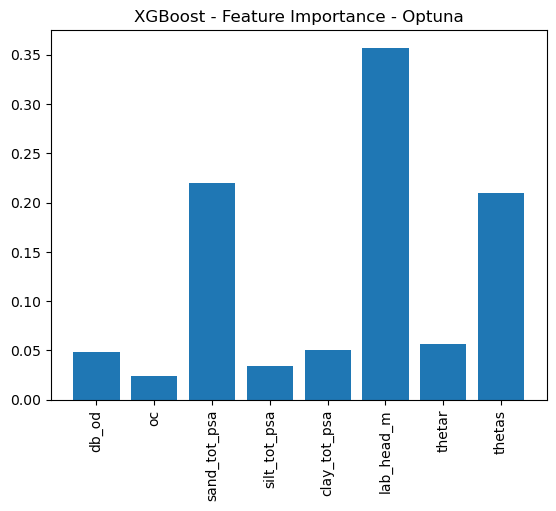

In [29]:
labels = ['db_od', 'oc', 'sand_tot_psa', 'silt_tot_psa', 'clay_tot_psa','lab_head_m', 'thetar', 'thetas']
plt.bar(labels, importance)
plt.xticks(rotation = 90)
plt.title('XGBoost - Feature Importance - Optuna')
plt.show()

In [30]:
y_pred = xgb_reg_opt.predict(X_test_s)

print_model_results('XGBoost Rregression - Optuna', y_test,y_pred)

XGBoost Rregression - Optuna:  R^2= 0.9847,  ME = 0.2496,  MAE = 0.0093,  MAPE = 0.0427


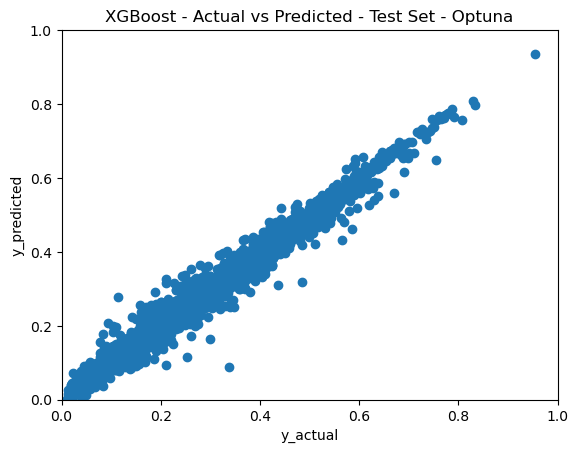

In [31]:
y_actual = y_test
plt.scatter(y_actual, y_pred)
plt.ylabel('y_predicted')
plt.xlabel('y_actual')
plt.title('XGBoost - Actual vs Predicted - Test Set - Optuna')
plt.xlim((0,1))
plt.ylim((0,1))
plt.show()

# Save the final model to a pickle file

In [32]:
import pickle

# Save the model to a file
pickle.dump(xgb_reg_opt, open("xgboost_swrc_regression_model.pickle", "wb"))

In [1]:
import pickle
# Load the saved model from file
loaded_model = pickle.load(open("xgboost_swrc_regression_model.pickle", "rb"))

In [35]:
# Use the loaded model to make predictions
predictions = loaded_model.predict(X_test_s)

# Save the scaler to a pickle file

In [2]:
# Save the scaler to a file
pickle.dump(scaler, open("xgboost_swrc_scaler.pickle", "wb"))

NameError: name 'scaler' is not defined

In [37]:
# Load the saved scaler from file
loaded_scaler = pickle.load(open("xgboost_swrc_scaler.pickle", "rb"))

# Apply the scaler to new data
scaled_data = loaded_scaler.transform(X_test)

# Save model to more compact Joblib file

In [3]:
import joblib


# Save the model to a file
joblib.dump(loaded_model, "xgboost_swrc_regression_model.joblib")

['xgboost_swrc_regression_model.joblib']

In [4]:
# Load the model from the joblib file
loaded_model_joblib = joblib.load("xgboost_swrc_regression_model.joblib")